In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt  

# preprocessing
from program.skin_functions.preprocessing import outer_circle_remover as outer_circle_remover
from program.skin_functions.preprocessing import hair_remover as hair_remover
from program.skin_functions.preprocessing import lbp_image_creator as lbp_image_creator
from program.skin_functions.postprocessing import postprocessing as postprocessing


# mask
from program.skin_functions.mask import mask_watershed_creator as mask_watershed_creator
from program.skin_functions.mask import refiner as refiner
from program.skin_functions.mask import label_meanshift_creator as label_meanshift_creator
from program.skin_functions.mask import label_em_creator as label_em_creator
from program.skin_functions.mask import mask_from_em234_labels_creator as mask_from_em234_labels_creator
from program.skin_functions.mask import mask_combinator as mask_combinator
from program.skin_functions.mask import mask_border_creator as mask_border_creator


# features extraction
from program.features_extraction import f_color as f_color
from program.features_extraction import f_texture_lbp as f_texture_lbp
from program.features_extraction import f_texture_glcm as f_texture_glcm
from program.features_extraction import f_shape_mask as f_shape_mask
from program.features_extraction import util as feat_util

# classification
from program.classification.classifier import Classifier

# functions
from program.functions import functions as fc


# Binary classification

## 1. Preprocessing

In [2]:
def jpg_compresion(img):
    _, buffer = cv.imencode('.jpg', img)
    return cv.imdecode(np.frombuffer(buffer, np.uint8), cv.IMREAD_COLOR)


In [3]:
img_path_name = "C:/Users/Agustin/portfolio/medical_imaging_projects/s3_skin_lesion_detection_ml/code/binary/program/images/original/train/benign/nev00002.jpg"
img_original = cv.imread(img_path_name)


# ------------ step 1: preprocessing - image preprocessed V0
img_prep_v0 = outer_circle_remover.remove_outer_circle(img_original, new_bg_color=None)
img_prep_v0 = jpg_compresion(img_prep_v0) # legacy code
 
# ------------ step 2: mask combined 
# -------- step 2.1: remove hairs
img_no_hairs = hair_remover.remove_hairs(img_prep_v0)
img_no_hairs = jpg_compresion(img_no_hairs) # legacy code

circular_mask = outer_circle_remover.get_preprocessed_circular_mask(img_original)
# -------- step 2.2: watershed mask
mask_wathershed = mask_watershed_creator.get_mask(img_no_hairs)
mask_wathershed_ref  = refiner.refine(mask_wathershed, circular_mask, medianb_size=7, resize_w=512, gaussian_factor=6)
# -------- step 2.3: probabilistic mask
labels_meanshift = label_meanshift_creator.get_labels(img_no_hairs, resize_w=256)
# labels_meanshift = jpg_compresion(labels_meanshift) # legacy code
labels_meanshift_em234= label_em_creator.get_labels(labels_meanshift, em_ks=[2,3,4], resize_w=256)
mask_v1 = mask_from_em234_labels_creator.get_best_prob_mask_V1(img_no_hairs, labels_meanshift_em234, circular_mask)
mask_v1  = refiner.refine(mask_v1, circular_mask, medianb_size=7, resize_w=512, gaussian_factor=6)
mask_v2 = mask_from_em234_labels_creator.get_best_prob_mask_V2(img_no_hairs, labels_meanshift_em234, circular_mask)
mask_v2  = refiner.refine(mask_v2, circular_mask, medianb_size=0, resize_w=512, gaussian_factor=6)
# -------- step 2.4: probabilistic mask
mask_combined = mask_combinator.combine_masks([mask_wathershed_ref, mask_v1, mask_v2], img_no_hairs)

# ------------ step 3: postprocessing
img_post, mask_post = postprocessing.postprocess1(img_original, img_prep_v0, mask_combined)
mask_post_inverted = cv.bitwise_not(mask_post)
mask_post_border = mask_border_creator.get_border_mask(mask_post)

# ------------ step 4: Features extractor
# -------- step 4.1: image features
# ---- step 4.1.1: color features
feat_img_color = f_color.f_extract_color(img_post)
# ---- step 4.1.2: lbp features
gray_image = cv.cvtColor(img_prep_v0, cv.COLOR_BGR2GRAY)
img_lbp = lbp_image_creator.get_multiple_lbp_img(gray_image, [1,2,3], 8).astype(np.uint8)
img_lbp = postprocessing.postprocess1(img_original, img_lbp)
feat_img_lbp = f_texture_lbp.f_extract_texture_lbp(img_lbp, args_dict={"multiple_radius":[1,2,3], "num_point": 8})
# ---- step 4.1.3: glcm features
feat_img_glcm = f_texture_glcm.f_extract_texture_glcm(img_post, args_dict={"gray_labels":None})

# -------- step 4.2: mask features
# ---- step 4.2.1: color features
feat_mask_color = f_color.f_extract_color_mask(img_post, {"mask":mask_post})
# ---- step 4.2.2: lbp features
feat_mask_lbp = f_texture_lbp.f_extract_texture_lbp_mask(img_lbp, args_dict={"mask":mask_post, "multiple_radius":[1,2,3], "num_point": 8})
# ---- step 4.2.3: glcm features
feat_mask_glcm = f_texture_glcm.f_extract_texture_glcm_mask(img_post, args_dict={"mask":mask_post, "gray_labels":None})
# ---- step 4.2.3: shape features
feat_mask_shape = f_shape_mask.f_extract_shape(img_post, {"mask":mask_post})

# -------- step 4.3: mask inverted features
# ---- step 4.3.1: color features
feat_mask_inv_color = f_color.f_extract_color_mask(img_post, {"mask":mask_post_inverted})
# ---- step 4.3.2: lbp features
feat_mask_inv_lbp = f_texture_lbp.f_extract_texture_lbp_mask(img_lbp, args_dict={"mask":mask_post_inverted, "multiple_radius":[1,2,3], "num_point": 8})
# ---- step 4.3.3: glcm features
feat_mask_inv_glcm = f_texture_glcm.f_extract_texture_glcm_mask(img_post, args_dict={"mask":mask_post_inverted, "gray_labels":None})


# -------- step 4.3: mask border features
# ---- step 4.3.1: color features
feat_mask_border_color = f_color.f_extract_color_mask(img_post, {"mask":mask_post_border})
# ---- step 4.3.2: lbp features
feat_mask_border_lbp = f_texture_lbp.f_extract_texture_lbp_mask(img_lbp, args_dict={"mask":mask_post_border, "multiple_radius":[1,2,3], "num_point": 8})
# ---- step 4.3.3: glcm features
feat_mask_border_glcm = f_texture_glcm.f_extract_texture_glcm_mask(img_post, args_dict={"mask":mask_post_border, "gray_labels":None})


# -------- step 4.4: spatial features
# ---- step 4.3.1: color features
feat_spatial_color = f_color.f_extract_color_mask_spatial(img_post, {"mask":mask_post})
# ---- step 4.3.2: lbp features
feat_spatial_lbp = f_texture_lbp.f_extract_texture_lbp_mask_spatial(img_lbp, args_dict={"mask":mask_post, "multiple_radius":[1,2,3], "num_point": 8})
# ---- step 4.3.3: glcm features
feat_spatial_glcm = f_texture_glcm.f_extract_texture_glcm_mask_spatial(img_post, args_dict={"mask":mask_post, "gray_labels":128})





step 1: remove outer circle


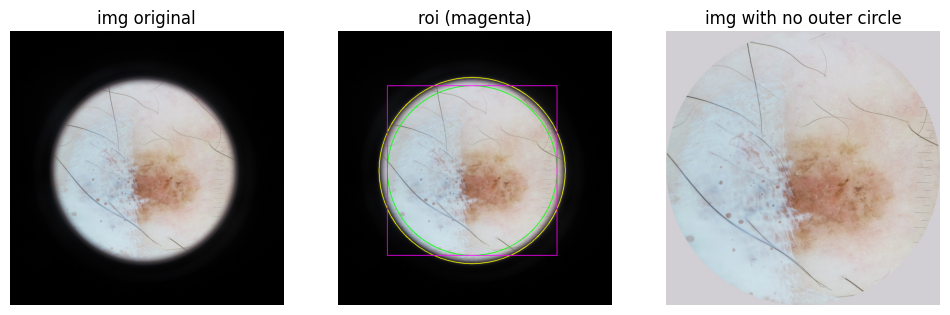

step 2.1: remove hairs


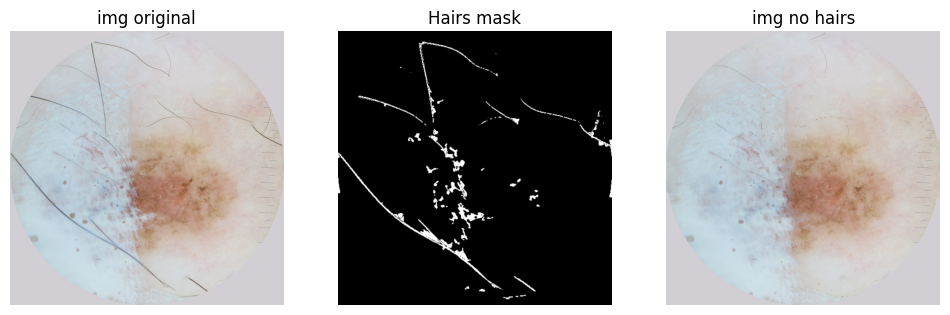

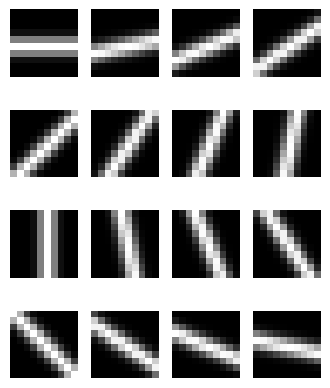

step 2.2: mask watershed


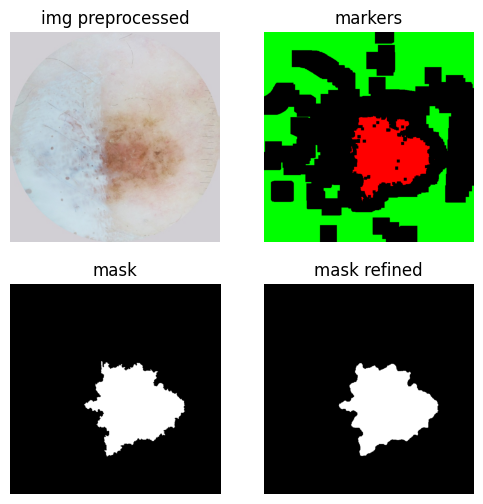

step 2.3: mask EM 234


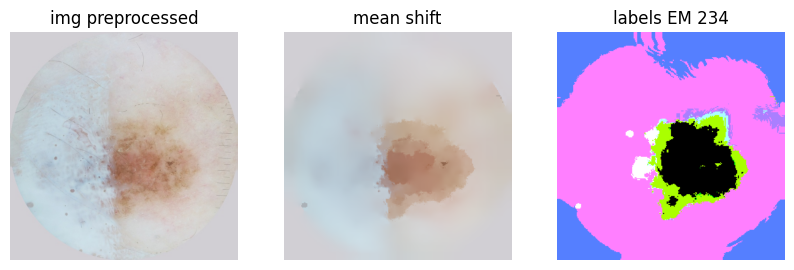

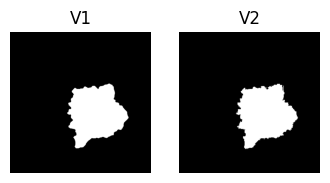

step 2.4: mask combined


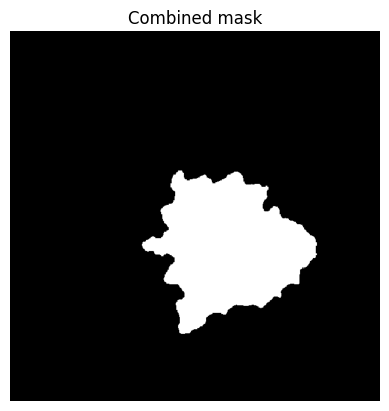

step 3: postprocessing


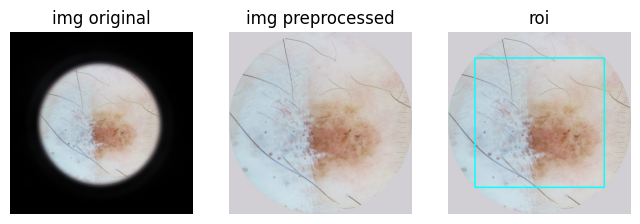

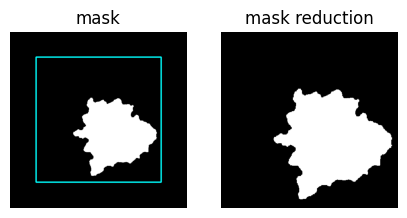

In [4]:

# ------ Show step 1 --------------------------
print("step 1: remove outer circle")
outher_circle, roi = outer_circle_remover.get_outer_circle(img_original, reduction_circel=0.1)
img_original_wm = fc.draw_circle(img_original, (outher_circle[0], int(outher_circle[1]*1.1)), color=(0,255,255), thickness=2)
img_original_wm = fc.draw_circle(img_original_wm, outher_circle, color=(0,255,0), thickness=2)
img_original_wm = fc.draw_roi(img_original_wm, roi, color=(255,0,255), thickness=2)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fc.imgshow_matplotlib("img original", img_original, bgr2rgb=True, subplot=axs[0])
fc.imgshow_matplotlib("roi (magenta)", img_original_wm, bgr2rgb=True, subplot=axs[1])
fc.imgshow_matplotlib("img with no outer circle", img_prep_v0, bgr2rgb=True, subplot=axs[2])
plt.show()
# ------ end to show step 1 --------------------------

# ------ to Show step 2.1 --------------------------
print("step 2.1: remove hairs")
hairs_mask = hair_remover.get_hairs_mask(img_prep_v0)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fc.imgshow_matplotlib("img original", img_prep_v0, bgr2rgb=True, subplot=axs[0])
fc.imgshow_matplotlib("Hairs mask", hairs_mask, bgr2rgb=False, subplot=axs[1])
fc.imgshow_matplotlib("img no hairs", img_no_hairs, bgr2rgb=True, subplot=axs[2])

fig2, axs2 = plt.subplots(4, 4, figsize=(4, 5))
se_bars = [fc.se_bar(10, angle) for angle in np.linspace(start=0, stop=180, num=16, endpoint=False)]
c = 0
for i in range(4):
    for j in range(4):
        fc.imgshow_matplotlib("", se_bars[c], bgr2rgb=False, subplot=axs2[i][j])
        c+=1
plt.show()
# ------ end to show step 2.1 --------------------------

# ------ to Show step 2.2 --------------------------
print("step 2.2: mask watershed")

img_mean_b_r = fc.compute_image_mean_channels(img_no_hairs, channels=[0,2], importance=[1,1])

# find markers
mask_lesion, mask_skin = mask_watershed_creator.get_lession_and_skin_mask(img_mean_b_r)
markers = np.zeros_like(img_no_hairs)
markers[...,2] = mask_lesion
markers[...,1] = mask_skin

fig, axs = plt.subplots(2, 2, figsize=(6, 6))
fc.imgshow_matplotlib("img preprocessed", img_no_hairs, bgr2rgb=True, subplot=axs[0][0])
fc.imgshow_matplotlib("markers", markers, bgr2rgb=True, subplot=axs[0][1])
fc.imgshow_matplotlib("mask", mask_wathershed, bgr2rgb=False, subplot=axs[1][0])
fc.imgshow_matplotlib("mask refined", mask_wathershed_ref, bgr2rgb=False, subplot=axs[1][1])
plt.show()
# ------ end to show step 2.2 --------------------------

# ------ to Show step 2.3 --------------------------
print("step 2.3: mask EM 234")
# preprocessed image
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
fc.imgshow_matplotlib("img preprocessed", img_no_hairs, bgr2rgb=True, subplot=axs[0])
fc.imgshow_matplotlib("mean shift", labels_meanshift, bgr2rgb=True, subplot=axs[1])
fc.imgshow_matplotlib("labels EM 234", labels_meanshift_em234, bgr2rgb=True, subplot=axs[2])

fig, axs = plt.subplots(1, 2, figsize=(4, 4))
fc.imgshow_matplotlib("V1", mask_v1, bgr2rgb=True, subplot=axs[0])
fc.imgshow_matplotlib("V2", mask_v2, bgr2rgb=True, subplot=axs[1])
plt.show()
# ------ end to show step 2.3 --------------------------

# ------ to Show step 2.4 --------------------------
print("step 2.4: mask combined")
fc.imgshow_matplotlib("Combined mask", mask_combined, bgr2rgb=False)
plt.show()
# ------ end to show step 2.4 --------------------------

# # ------ to Show step 3 --------------------------
print("step 3: postprocessing")
roi = postprocessing.get_reduced_roi_if_outher_circle(img_original)
if roi is not None:
    img_prep_wm = fc.draw_roi(img_prep_v0, roi, color=(255,255,0), thickness=3)
    mask_wm = fc.draw_roi(mask_combined, roi, color=(255,255,0), thickness=3)

fig, axs = plt.subplots(1, 3, figsize=(8, 8))
fc.imgshow_matplotlib("img original", img_original, bgr2rgb=True, subplot=axs[0])
fc.imgshow_matplotlib("img preprocessed", img_prep_v0, bgr2rgb=True, subplot=axs[1])
fc.imgshow_matplotlib("roi", img_prep_wm, bgr2rgb=True, subplot=axs[2])

# post processing
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
fc.imgshow_matplotlib("mask", mask_wm, bgr2rgb=True, subplot=axs[0])
fc.imgshow_matplotlib("mask reduction", mask_post, bgr2rgb=True, subplot=axs[1])
# # ------ end to show step 3 --------------------------




## Extracted features

### Shape

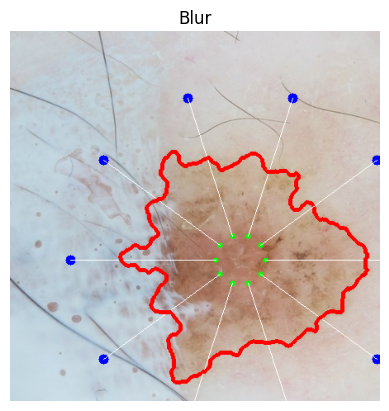

In [5]:
roi = postprocessing.get_reduced_roi_if_outher_circle(img_original)

# blur
contours = fc.get_contours(mask_post, order_by_area=True)
contour = contours[0]

_,_,w,h = cv.boundingRect(contour)
centroid = fc.get_contour_centroid(contour)
init_points = fc.get_circle_points(mask_combined.shape, 10, 30, centroid)
end_points = fc.get_circle_points(mask_combined.shape, 10, np.sqrt((w/2)**2 + (h/2)**2), centroid)

img_prep_wm = img_post.copy()
for i in range(len(init_points)):
    img_prep_wm = fc.draw_mask(img_prep_wm, mask_post, thickness=4, mask_color=(0,0,255))
    img_prep_wm = fc.draw_point(img_prep_wm, init_points[i], radius=3, color=(0,255,0))
    img_prep_wm = fc.draw_point(img_prep_wm, end_points[i], radius=6, color=(255,0,0))
    img_prep_wm = fc.draw_line(img_prep_wm, (*end_points[i], *init_points[i]), color=(255,255,255))


fc.imgshow_matplotlib("Blur", img_prep_wm, bgr2rgb=True)


### Used masks

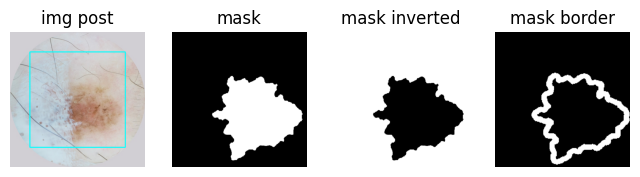

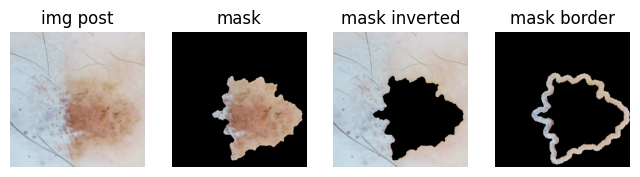

In [6]:
# img_post, 

if roi is not None:
    img_prep_wm = fc.draw_roi(img_prep_v0, roi, color=(255,255,0), thickness=3)
    
fig, axs = plt.subplots(1, 4, figsize=(8, 8))
fc.imgshow_matplotlib("img post", img_prep_wm, bgr2rgb=True, subplot=axs[0])
fc.imgshow_matplotlib("mask", mask_post, bgr2rgb=True, subplot=axs[1])
fc.imgshow_matplotlib("mask inverted", mask_post_inverted, bgr2rgb=True, subplot=axs[2])
fc.imgshow_matplotlib("mask border", mask_post_border, bgr2rgb=True, subplot=axs[3])



fig, axs = plt.subplots(1, 4, figsize=(8, 8))
img_post_mask = fc.apply_mask(img_post, mask_post, mask_value=-1)
img_post_mask_inverted = fc.apply_mask(img_post, mask_post_inverted, mask_value=-1)
img_post_mask_border= fc.apply_mask(img_post, mask_post_border, mask_value=-1)
fc.imgshow_matplotlib("img post", img_post, bgr2rgb=True, subplot=axs[0])
fc.imgshow_matplotlib("mask", img_post_mask, bgr2rgb=True, subplot=axs[1])
fc.imgshow_matplotlib("mask inverted", img_post_mask_inverted, bgr2rgb=True, subplot=axs[2])
fc.imgshow_matplotlib("mask border", img_post_mask_border, bgr2rgb=True, subplot=axs[3])



#### Spatia information

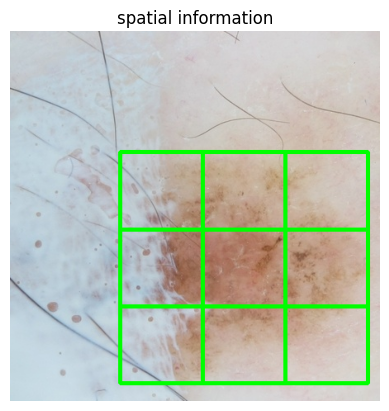

In [7]:
img_shape = img_post.shape[:2]
i_roi = feat_util.get_target_roi(img_shape, mask_post)
boundaries = feat_util.divide_roi(i_roi, 3, img_shape, 3, 3)
all_feat = []

img_prep_wm = img_post.copy()
# obtaining features
for roi in boundaries:
    img_prep_wm = fc.draw_roi(img_prep_wm, roi, color=(0,255,0), thickness=3)
fc.imgshow_matplotlib("spatial information", img_prep_wm, bgr2rgb=True)


